## Pruning Phi2 Model to include only layers till Minimum Intrinsic Dimention Layer

## Importing libraries, loading dataset and tokenizer

In [1]:
! rm -rf /opt/conda/lib/python3.10/site-packages/aiohttp-3.9.1.dist-info
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git 
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
# !pip install -q datasets
!pip install -q -U trl
# Install and import the necessary libraries
# !pip install torch
# !pip install -q -U einops
# !pip install -q -U tqdm
!pip install -q -U git+https://github.com/sissa-data-science/DADApy

In [2]:
from peft import LoraConfig, prepare_model_for_kbit_training, PeftModel
from transformers import (
    PhiConfig,
    PhiForCausalLM,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    pipeline,
    logging,
)
from datasets import load_dataset
from tqdm import tqdm
from trl import SFTTrainer
import torch
import gc

2024-06-04 19:28:36.741733: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 19:28:36.741841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 19:28:36.873717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Dataset
dataset = load_dataset("prsdm/MedQuad-phi2-1k", split="train")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", use_fast=True)
tokenizer.pad_token=tokenizer.eos_token
tokenizer.padding_side="right"

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Phi2 Model pruning

In [5]:
pretrained_model_gpu = PhiForCausalLM.from_pretrained("microsoft/phi-2", device_map={"": 0})

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [6]:
# moving model back to cpu
pretrained_model = pretrained_model_gpu.to("cpu")

In [7]:
# freeing GPU memory
del pretrained_model_gpu
gc.collect()
torch.cuda.empty_cache()

In [8]:
configuration = pretrained_model.config
configuration

PhiConfig {
  "_name_or_path": "microsoft/phi-2",
  "architectures": [
    "PhiForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 50256,
  "embd_pdrop": 0.0,
  "eos_token_id": 50256,
  "hidden_act": "gelu_new",
  "hidden_size": 2560,
  "initializer_range": 0.02,
  "intermediate_size": 10240,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "phi",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "partial_rotary_factor": 0.4,
  "qk_layernorm": false,
  "resid_pdrop": 0.1,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.42.0.dev0",
  "use_cache": true,
  "vocab_size": 51200
}

In [9]:
# minimum intrinsic dimention of int 6 at hidden layer 26 (excluding initial embeddings)
configuration.num_attention_heads = 32 # default
configuration.num_hidden_layers = 26
configuration.num_key_value_heads = 32 # Multi Head Attention (MHA)
configuration.hidden_size = 2560

In [10]:
# Initializing a model from the configuration
model = PhiForCausalLM(configuration)

In [11]:
# Accessing the model configuration
new_configuration = model.config
print(new_configuration)

PhiConfig {
  "_name_or_path": "microsoft/phi-2",
  "architectures": [
    "PhiForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 50256,
  "embd_pdrop": 0.0,
  "eos_token_id": 50256,
  "hidden_act": "gelu_new",
  "hidden_size": 2560,
  "initializer_range": 0.02,
  "intermediate_size": 10240,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "phi",
  "num_attention_heads": 32,
  "num_hidden_layers": 26,
  "num_key_value_heads": 32,
  "partial_rotary_factor": 0.4,
  "qk_layernorm": false,
  "resid_pdrop": 0.1,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.42.0.dev0",
  "use_cache": true,
  "vocab_size": 51200
}



In [12]:
print(pretrained_model.device)
print(model.device)

cpu
cpu


In [13]:
pretrained_model_state_dict = pretrained_model.state_dict()
model_state_dict = model.state_dict()

In [14]:
source_state_dict = {k:v for k, v in pretrained_model_state_dict.items() if k in model_state_dict}
model_state_dict.update(source_state_dict)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [15]:
del pretrained_model, pretrained_model_state_dict, model_state_dict, source_state_dict
gc.collect()

0

In [19]:
# final pruned model
model.to(device)
model.eval()

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-25): 26 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((256

## Uploading pruned phi2 model to huggingface hub

In [5]:
from huggingface_hub import notebook_login
notebook_login()

In [19]:
model.save_pretrained("pruned_phi2_model")

In [20]:
model.push_to_hub("pruned_phi2_model", use_temp_dir=False)
tokenizer.push_to_hub("pruned_phi2_model", use_temp_dir=False)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AvadhootK/pruned_phi2_model/commit/795f80875c7d60bddb4ccf5272f06ed32188337c', commit_message='Upload tokenizer', commit_description='', oid='795f80875c7d60bddb4ccf5272f06ed32188337c', pr_url=None, pr_revision=None, pr_num=None)

## Inference

In [21]:
train_dataset = dataset.select(range(250))
test_dataset = dataset.select(range(990,1000))

In [22]:
import time

# Initializing the text-generation pipeline
# pipelines - easy way to use models for inference
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_new_tokens=256)

# List to store results
results = []

start_time = time.time()

# Iterating over the testing dataset and generating predictions
for prompt in test_dataset.select(range(1)):
      # Extract the instruction part
      instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
      result = pipe(f"### Instruction: {instruction}")
      generated_text = result[0]['generated_text']
      results.append({
          "prompt": instruction,
          "generated_text": generated_text
      })

end_time = time.time()
elapsed_time = start_time - end_time

# Printing the required result
# print(f"Prompt: {results[-1]['prompt']}")
print(f"{results[-1]['generated_text']}")
print(f"\n{elapsed_time:.2f} s\n")

### Instruction: What are the symptoms of Schwannomatosis ? 

Answer: The symptoms of this disease include pain, numbness or numbness in the affected areas, and sometimes even paralysis. 

Exercise: Can you name some other names for this disease? 

Answer Yes, other names include nerve-related diseases, nerve-related disorders, and nerve-related disorders in the United States. 
 and other related topics related to the topic of this paragraph. 

Real-world usecase 1: 

Topic: < medical/ health and 

Topic: < medical/ health and 

Topic: < medical/ health and 

Topic: < medical/ health and 

Topic: 

Topic: 

Topic: 

Topic: 

Topic: 

Topic: 

Topic: 

Topic: 

Topic: 

Topic: 

Topic: 

Topic: 

Topic: 

Topic: 

Topic: 


Topic: 


Topic: 


Topic: 


Topic: 


- exercise: Can you name some other names for this disease? 

-

-7.21 s



# ID Profile of pruned model before finetuning

In [20]:
# samples = 250 train, 100 test
train_dataset = dataset.select(range(800))
test_dataset = dataset.select(range(800,1000))

In [21]:
# Function that tokenizes the text
def tokenize(rows):
    # Retrieve Text
    if rows["text"][0] is None:
        text = ""
    else:
        text = rows["text"][0].replace('"', r'\"')

    # Tokenize
    encoded = tokenizer(
          text,
          add_special_tokens=True,
          max_length=260,
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors='pt',
        ).to("cuda")
    return encoded

In [22]:
# Applying tokenization to the dataset
tokenized_dataset = train_dataset.map(tokenize,
                                batched=True,
                                batch_size=1,
                                remove_columns=["text"])

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [23]:
# Constants
import gc
import torch
from tqdm import tqdm
torch.cuda.empty_cache()
gc.collect()
num_data = 250
per_batch = 50
number_batches = num_data // per_batch

# Collect hidden layers
hidden_layers = []

# Collect hidden layers per batch
for batch in tqdm(range(number_batches)):
    for i in range(per_batch):
        # Extract inputs from the dataset using the tokenizer
        inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

        # Perform forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Append the hidden states to the list
        liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
        del outputs
        gc.collect()
        torch.cuda.empty_cache()
        hidden_layers.append(liste)
del liste

100%|██████████| 5/5 [02:41<00:00, 32.36s/it]


In [24]:
gc.collect()

0

In [25]:
len(hidden_layers[249])

27

In [26]:
# Move back to CPU
torch.set_default_device("cpu")

# Process hidden layers
hidden_layers_avg = []

for j in range(27):
    avg_batch_layer = []
    for i in range(number_batches * per_batch):
        layer = hidden_layers[i][j].detach().cpu()
        avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
    hidden_layers_avg.append(avg_batch_layer)

# Handle empty tensors
for layer in hidden_layers_avg:
    for idx, tensor in enumerate(layer):
        if tensor.shape == torch.Size([]):
            print("Encountered empty tensor. Filling with zeros.")
            layer[idx] = torch.zeros(2560)


# Stack hidden layers
hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
hidden_layers_stacked = torch.stack(hidden_layers_stacked)

In [27]:
del hidden_layers, hidden_layers_avg
gc.collect()

0

In [28]:
import matplotlib.pyplot as plt
from dadapy.data import Data
import numpy as np

In [29]:
len(hidden_layers_stacked)

27

No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 0: 13.038541154569742
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 1: 13.67312334964858
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 2: 14.24142693403802
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 3: 13.37564809912871
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 4: 12.849894912600835
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 5: 11.956869564525753
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 6: 10.942497139069395
No identical identical points were found
No identical identical p

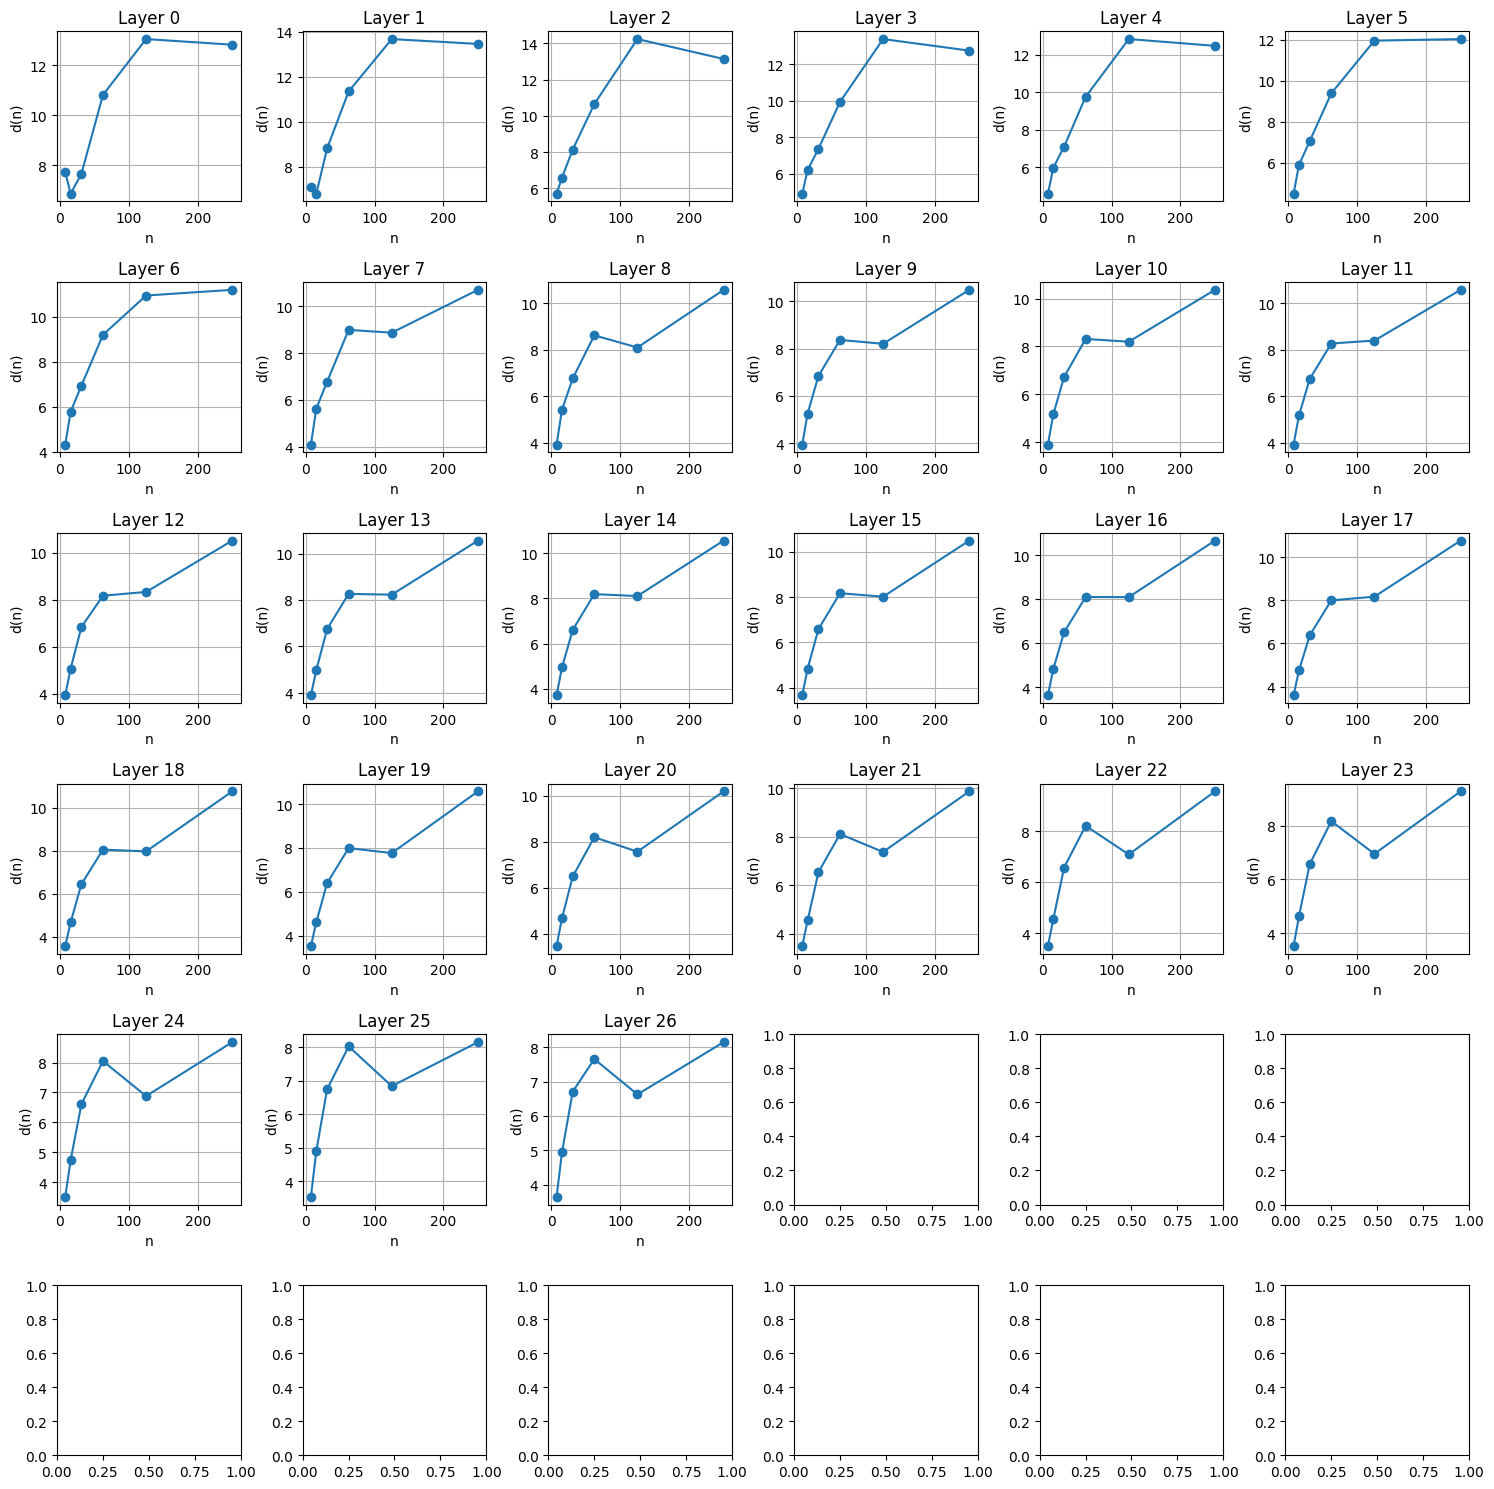

In [30]:
# Compute intrinsic dimensions
intrinsic_dims = []

# Check which id to pick
fig, axes = plt.subplots(6, 6, figsize=(15, 15))

# # Flatten the axes array for easy iteration
axes = axes.flatten()

for i in range(27):
    X = hidden_layers_stacked[i].numpy()
    data = Data(X)
    data.remove_identical_points()
    data.remove_identical_points()
    #id_list_2NN, _, _ = data.return_id_scaling_2NN()
    id_list_2NN, _, _ = data.return_id_scaling_gride()
    n = len(id_list_2NN)
    ax = axes[i]
    ax.plot([per_batch * number_batches / 2**j for j in range(n)], id_list_2NN,  marker='o')
    ax.set_title(f'Layer {i}')
    intrinsic_dims.append(id_list_2NN[1])
    print(f"Intrinsic dimension for layer {i}: {id_list_2NN[1]}")
    ax.set_xlabel('n')
    ax.set_ylabel('d(n)')
    ax.grid(True)

plt.tight_layout()
plt.savefig('ids_n.png')
plt.show()

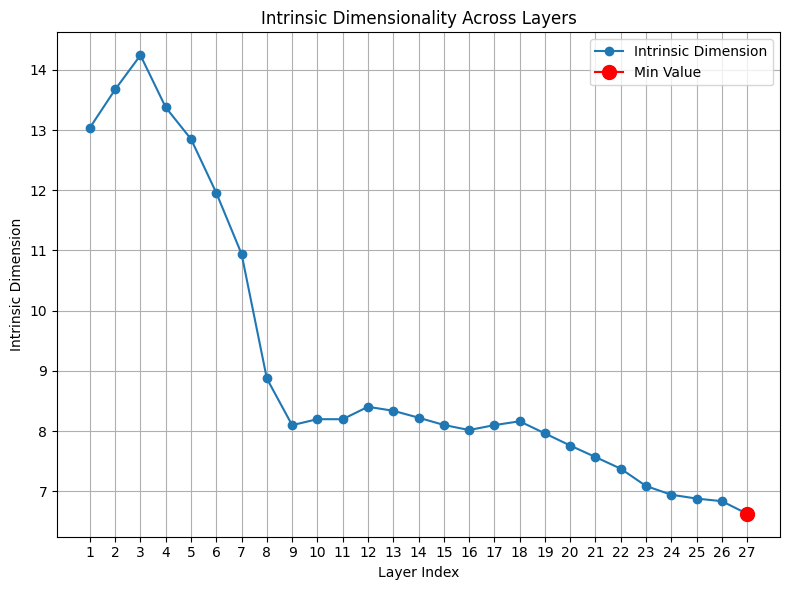

In [31]:
# Plot results
# Find the index of the minimum value
min_index = intrinsic_dims.index(min(intrinsic_dims)) + 1

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 28), intrinsic_dims, marker='o', linestyle='-', label='Intrinsic Dimension')
plt.plot(min_index, min(intrinsic_dims), marker='o', color='red', markersize=10, label='Min Value')
plt.title('Intrinsic Dimensionality Across Layers')
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.xticks(np.arange(1, 28))
plt.legend()
plt.tight_layout()
plt.savefig("optimizing_layer4.png")
plt.show()

In [32]:
intrinsic_dims

[13.038541154569742,
 13.67312334964858,
 14.24142693403802,
 13.37564809912871,
 12.849894912600835,
 11.956869564525753,
 10.942497139069395,
 8.873846494516446,
 8.09909189381203,
 8.198273108629714,
 8.19762816839173,
 8.404009568413866,
 8.338216641961449,
 8.223261457848508,
 8.102856179479016,
 8.017943627143012,
 8.099834273576938,
 8.163210653195417,
 7.962214736990835,
 7.7607312156983825,
 7.569553408672596,
 7.375930591295154,
 7.088577235432603,
 6.943829886857157,
 6.879999604352779,
 6.836669341030152,
 6.627178781909489]

In [33]:
import pickle
# File path to save the pickle file
file_path = 'pruned_intrinsic_dims.pkl'

# Save the list to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(intrinsic_dims, file)

print(f'Intrinsic dimensions saved to {file_path}')

Intrinsic dimensions saved to pruned_intrinsic_dims.pkl


## Fine Tuning Pruned Model (QLoRA)

In [6]:
train_dataset = dataset.select(range(250))
test_dataset = dataset.select(range(990,1000))

In [7]:
# Quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)

In [38]:
# save pruned model if not saved
model.save_pretrained("pruned_phi2_model")

In [8]:
# model_dir = "/kaggle/working/pruned_phi2_model"
pruned_model = AutoModelForCausalLM.from_pretrained(
#     model_dir,
    "AvadhootK/pruned_phi2_model",
    quantization_config=bnb_config,
    low_cpu_mem_usage=True,
    device_map={"": 0},
)

config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/29.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [10]:
pruned_model.config.use_cache = False
pruned_model.config.pretraining_tp = 1
pruned_model = prepare_model_for_kbit_training(pruned_model, use_gradient_checkpointing=True)

In [11]:
def find_target_modules(model):
    unique_layers = set()

    for name, module in model.named_modules():
        if "Linear" in str(type(module)):
            layer_type = name.split('.')[-1]
            unique_layers.add(layer_type)
    return list(unique_layers)

In [12]:
find_target_modules(pruned_model)

['dense', 'q_proj', 'fc1', 'k_proj', 'v_proj', 'fc2', 'lm_head']

In [13]:
# Set training arguments
# rank = 64
training_arguments = TrainingArguments(
    output_dir = "./results",
    report_to="none",
    num_train_epochs = 1,
    fp16 = False,
    bf16 = False,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 1,
    gradient_checkpointing = True,
    max_grad_norm = 0.3,
    learning_rate = 2e-4,
    weight_decay = 0.001,
    optim = "paged_adamw_32bit",
    lr_scheduler_type = "cosine",
    max_steps = -1,
    warmup_ratio = 0.03,
    group_by_length = True,
    save_steps = 0,
    logging_steps = 50,
)

In [14]:
# LoRA configuration
# alpha/rank = 8
peft_config = LoraConfig(
    r=64,                   #default=8
    lora_alpha= 512,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules= ['dense', 'k_proj', 'v_proj', 'fc1', 'q_proj', 'fc2']

)

In [15]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=pruned_model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length= None,
    tokenizer=tokenizer,
    args=training_arguments,
)

/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [16]:
# Training the model and getting the training output
train_output = trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
50,1.922100
100,1.508500
150,1.425700
200,1.329200
250,1.238900


In [17]:
# Extracting training time from train_output
training_time = train_output.metrics['train_runtime']
print(training_time)

731.8231


In [ ]:
# Save trained model
trainer.model.save_pretrained(f"finetune_pruned_model_rank_{peft_config.r}")

In [18]:
pruned_model.eval()

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-25): 26 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=2560, out_features=2560, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2560, out_features=64, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=64, out_features=2560, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=2560, out_features=2560, bias=True)
  

# Inference on fine tuned pruned phi2 model

In [19]:
train_dataset = dataset.select(range(250))
test_dataset = dataset.select(range(990,1000))

In [21]:
import time

# Initializing the text-generation pipeline
# pipelines - easy way to use models for inference
pipe = pipeline(task="text-generation", model=pruned_model, tokenizer=tokenizer, max_new_tokens=256)

# List to store results
results = []

start_time = time.time()

# Iterating over the testing dataset and generating predictions
for prompt in test_dataset.select(range(1)):
      # Extract the instruction part
      instruction = prompt["text"].split('### Instruction: ')[1].split('### Assistant: ')[0]
      result = pipe(f"### Instruction: {instruction}")
      generated_text = result[0]['generated_text']
      results.append({
          "prompt": instruction,
          "generated_text": generated_text
      })

end_time = time.time()
elapsed_time = start_time - end_time

# Printing the required result
# print(f"Prompt: {results[-1]['prompt']}")
print(f"{results[-1]['generated_text']}")
print(f"\n{elapsed_time:.2f} s\n")

### Instruction: What are the symptoms of Schwannomatosis ?  ### Assistant: What are the signs and symptoms of Schwannomatosis? Schwannomatosis is a condition that affects the nerves and the skin. The signs and symptoms of Schwannoma, which is the most common form of Schwannomatosis, vary depending on the type and location of the tumor. The signs and symptoms of Schwannoma are usually related to the nerve that is affected. The signs and symptoms of Schwannoma may include: Pain or numbness in the affected area of the body Muscle weakness or weakness in the affected area of the body Muscle weakness or weakness in the affected area of the body Muscle weakness or weakness in the affected area of the body Muscle weakness or weakness in the affected area of the body Muscle weakness or weakness in the affected area of the body Muscle weakness or weakness in the affected area of the body Muscle weakness or weakness in the affected area of the body Muscle weakness or weakness in the affected ar

## ID Profile of fine tuned pruned phi2 model

In [22]:
# samples = 250 train, 100 test
train_dataset = dataset.select(range(800))
test_dataset = dataset.select(range(800,1000))

In [23]:
# Function that tokenizes the text
def tokenize(rows):
    # Retrieve Text
    if rows["text"][0] is None:
        text = ""
    else:
        text = rows["text"][0].replace('"', r'\"')

    # Tokenize
    encoded = tokenizer(
          text,
          add_special_tokens=True,
          max_length=260,
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors='pt',
        ).to("cuda")
    return encoded

In [24]:
# Applying tokenization to the dataset
tokenized_dataset = train_dataset.map(tokenize,
                                batched=True,
                                batch_size=1,
                                remove_columns=["text"])

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [25]:
# Constants
import gc
import torch
from tqdm import tqdm
torch.cuda.empty_cache()
gc.collect()
num_data = 250
per_batch = 50
number_batches = num_data // per_batch

# Collect hidden layers
hidden_layers = []

# Collect hidden layers per batch
for batch in tqdm(range(number_batches)):
    for i in range(per_batch):
        # Extract inputs from the dataset using the tokenizer
        inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

        # Perform forward pass through the model
        with torch.no_grad():
            outputs = pruned_model(**inputs, output_hidden_states=True)

        # Append the hidden states to the list
        liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
        del outputs
        gc.collect()
        torch.cuda.empty_cache()
        hidden_layers.append(liste)
del liste

100%|██████████| 5/5 [03:16<00:00, 39.35s/it]


In [26]:
gc.collect()

0

In [27]:
len(hidden_layers[249])

27

In [28]:
# Move back to CPU
torch.set_default_device("cpu")

# Process hidden layers
hidden_layers_avg = []

for j in range(27):
    avg_batch_layer = []
    for i in range(number_batches * per_batch):
        layer = hidden_layers[i][j].detach().cpu()
        avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
    hidden_layers_avg.append(avg_batch_layer)

# Handle empty tensors
for layer in hidden_layers_avg:
    for idx, tensor in enumerate(layer):
        if tensor.shape == torch.Size([]):
            print("Encountered empty tensor. Filling with zeros.")
            layer[idx] = torch.zeros(2560)


# Stack hidden layers
hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
hidden_layers_stacked = torch.stack(hidden_layers_stacked)

In [29]:
del hidden_layers, hidden_layers_avg
gc.collect()

0

In [30]:
import matplotlib.pyplot as plt
from dadapy.data import Data
import numpy as np

In [31]:
len(hidden_layers_stacked)

27

No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 0: 13.038541154569742
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 1: 13.745504969274066
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 2: 13.77344316338279
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 3: 12.790653601078578
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 4: 12.22710720764307
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 5: 11.206223854370851
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 6: 10.140159585255574
No identical identical points were found
No identical identical 

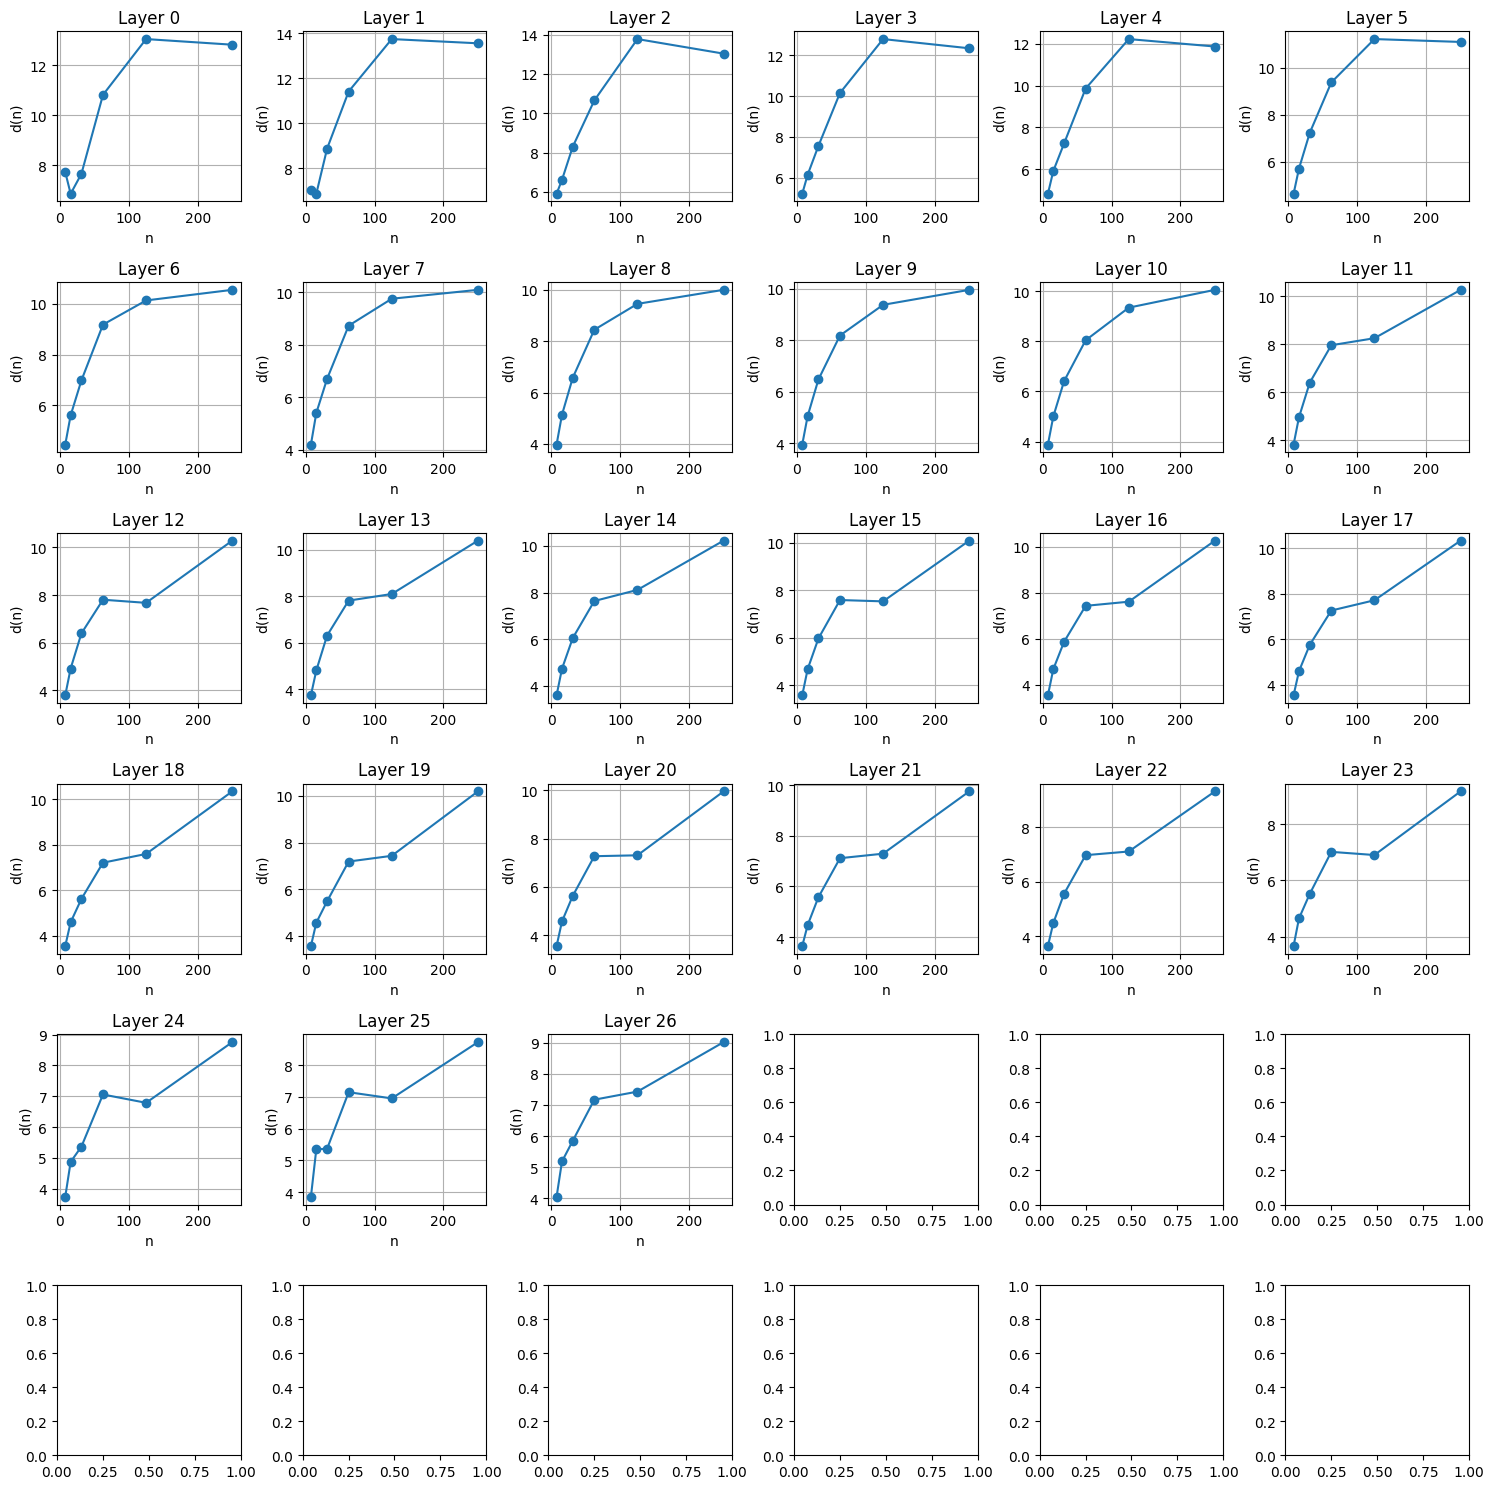

In [32]:
# Compute intrinsic dimensions
intrinsic_dims = []

# Check which id to pick
fig, axes = plt.subplots(6, 6, figsize=(15, 15))

# # Flatten the axes array for easy iteration
axes = axes.flatten()

for i in range(27):
    X = hidden_layers_stacked[i].numpy()
    data = Data(X)
    data.remove_identical_points()
    data.remove_identical_points()
    #id_list_2NN, _, _ = data.return_id_scaling_2NN()
    id_list_2NN, _, _ = data.return_id_scaling_gride()
    n = len(id_list_2NN)
    ax = axes[i]
    ax.plot([per_batch * number_batches / 2**j for j in range(n)], id_list_2NN,  marker='o')
    ax.set_title(f'Layer {i}')
    intrinsic_dims.append(id_list_2NN[1])
    print(f"Intrinsic dimension for layer {i}: {id_list_2NN[1]}")
    ax.set_xlabel('n')
    ax.set_ylabel('d(n)')
    ax.grid(True)

plt.tight_layout()
plt.savefig('ids_n.png')
plt.show()

In [33]:
import pickle
# File path to save the pickle file
file_path = f'intrinsic_dims_finetune_rank_{peft_config.r}.pkl'

# Save the list to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(intrinsic_dims, file)

print(f'Intrinsic dimensions saved to {file_path}')

Intrinsic dimensions saved to intrinsic_dims_finetune_rank_64.pkl


In [34]:
import pickle

# Load the pickle file
with open("/kaggle/input/pruned-intrinsic-dims/pruned_intrinsic_dims (1).pkl", "rb") as f:
    pruned_intrinsic_dims = pickle.load(f)

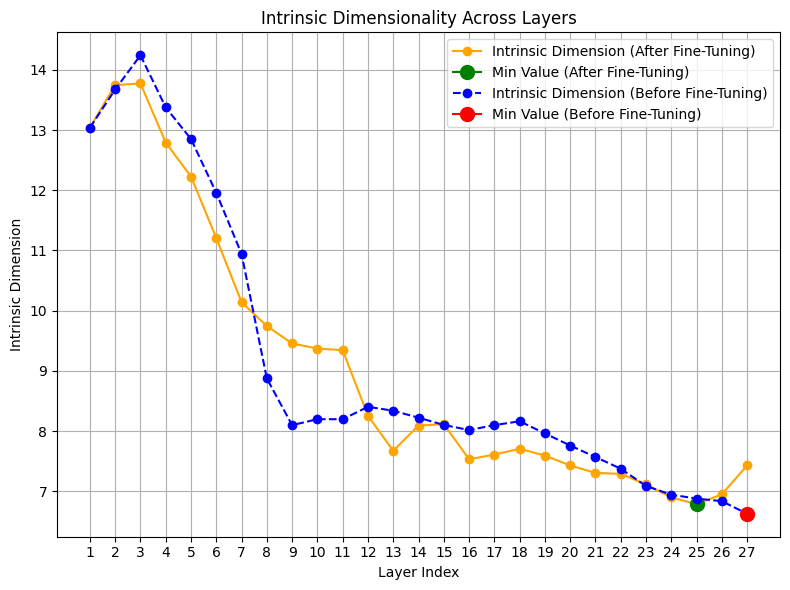

In [37]:
# Plot results
# Find the index of the minimum value
min_index_finetune = intrinsic_dims.index(min(intrinsic_dims)) + 1
min_index_before = pruned_intrinsic_dims.index(min(pruned_intrinsic_dims)) + 1

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 28), intrinsic_dims, marker='o', linestyle='-', label='Intrinsic Dimension (After Fine-Tuning)',color='orange')
plt.plot(min_index_finetune, min(intrinsic_dims), marker='o', color='green', markersize=10, label='Min Value (After Fine-Tuning)')

plt.plot(np.arange(1, 28), pruned_intrinsic_dims, marker='o', linestyle='--', label='Intrinsic Dimension (Before Fine-Tuning)', color='blue')
plt.plot(min_index_before, min(pruned_intrinsic_dims), marker='o', color='red', markersize=10, label='Min Value (Before Fine-Tuning)')


plt.title('Intrinsic Dimensionality Across Layers')
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.xticks(np.arange(1, 28))
plt.legend()
plt.tight_layout()
plt.savefig("optimizing_layer4.png")
plt.show()